# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of four classes: Normal, Viral, Pneumonio, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

### About COVID-19 Dataset
A database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19 dataset contains 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images.

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [2]:
print('cuda available' if torch.cuda.is_available() else 'cuda not available')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

cuda available
device: cuda:0


# Data Preparation

In [26]:
class_names = ['normal', 'viral', 'covid', 'lung']
class_fullnames = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung Opacity']

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']
root_dir = 'COVID-19_Radiography_Dataset'

if not os.path.isdir(os.path.join(root_dir, 'test')):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
        for i, d in enumerate(source_dirs):
            os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)
            
if not os.path.isdir(os.path.join(root_dir, 'valid')):
    os.mkdir(os.path.join(root_dir, 'valid'))
    
    if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
        for i, d in enumerate(source_dirs):
            os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'valid', c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'valid', c, image)
            shutil.move(source_path, target_path) 

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = class_names
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, idx):
        class_name = random.choice(self.class_names)
        idx = idx % len(self.images[class_name])
        image_name = self.images[class_name][idx]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

In [5]:
train_transform = torchvision.transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [7]:
train_dirs = {'normal': os.path.join(root_dir, 'normal'),
                'lung': os.path.join(root_dir, 'lung'),
               'covid': os.path.join(root_dir, 'covid'),
               'viral': os.path.join(root_dir, 'viral')}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10132 normal examples
Found 1285 viral examples
Found 3556 covid examples
Found 5952 lung examples


In [8]:
test_dirs = {'normal': os.path.join(root_dir, 'test', 'normal'),
               'lung': os.path.join(root_dir, 'test', 'lung'),
              'covid': os.path.join(root_dir, 'test', 'covid'),
              'viral': os.path.join(root_dir, 'test', 'viral')}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples
Found 30 lung examples


In [9]:
valid_dirs = {'normal': os.path.join(root_dir, 'valid', 'normal'),
               'lung': os.path.join(root_dir, 'valid', 'lung'),
              'covid': os.path.join(root_dir, 'valid', 'covid'),
              'viral': os.path.join(root_dir, 'valid', 'viral')}

valid_dataset = ChestXRayDataset(valid_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples
Found 30 lung examples


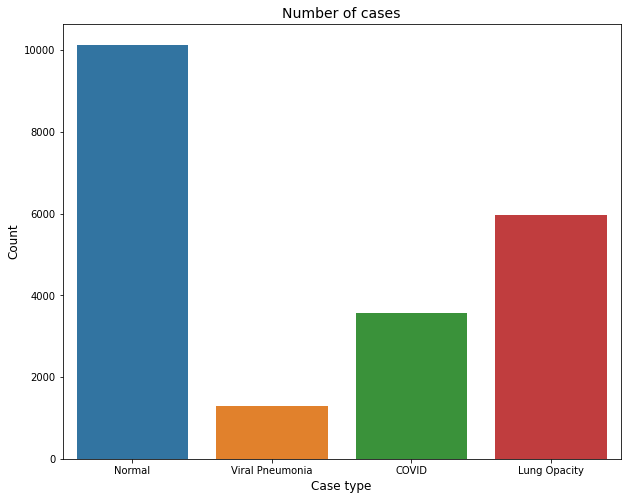

In [27]:
cases_count = []
for class_name in class_names:
    cases_count.append(len(train_dataset.images[class_name]))

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=class_fullnames, y=cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [11]:
batch_size = 6

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.cpu().detach().numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)

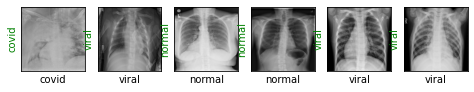

In [13]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

# Modeling

In [14]:
resnet18 = models.resnet18(pretrained=True)

In [15]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [17]:
resnet18 = resnet18.to(device)

In [18]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = resnet18(images)
    outputs = outputs.cpu().detach()
    print(outputs.shape)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

/home/fodics/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([6, 4])


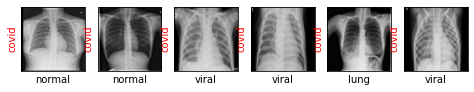

In [19]:
show_preds()

In [20]:
def train(epochs):
    
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(valid_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = resnet18(images)
                    loss = criterion(outputs, labels)
                    val_loss = loss.item()
                    _, preds = torch.max(outputs, 1)
                    preds = preds.cpu().detach()
                    labels = labels.cpu().detach()
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(valid_dataset)
                print(f'Val loss: {val_loss:.6f}, Acc: {acc:.6f}')
                
                resnet18.train()
                
                if acc > 0.99:
                    return 
                
            train_loss /= (train_step + 1)
            print(f'Training loss: {train_loss:.6f}')

In [21]:
train(epochs=1)

Starting epoch 1/1
Evaluating at step 0
Val loss: 0.080682, Acc: 0.216667
Training loss: 1.713650
Training loss: 1.437936
Training loss: 0.988488
Training loss: 0.559450
Training loss: 0.389113
Training loss: 0.296823
Training loss: 0.201444
Training loss: 0.179306
Training loss: 0.162575
Training loss: 0.112541
Training loss: 0.119210
Training loss: 0.127629
Training loss: 0.077140
Training loss: 0.083403
Training loss: 0.058596
Training loss: 0.065738
Training loss: 0.059407
Training loss: 0.056239
Training loss: 0.060417
Training loss: 0.058426
Evaluating at step 20
Val loss: 0.056970, Acc: 0.583333
Training loss: 0.044106
Training loss: 0.039515
Training loss: 0.053998
Training loss: 0.049488
Training loss: 0.043261
Training loss: 0.034105
Training loss: 0.031954
Training loss: 0.028193
Training loss: 0.042869
Training loss: 0.034696
Training loss: 0.026843
Training loss: 0.035456
Training loss: 0.018042
Training loss: 0.021558
Training loss: 0.022137
Training loss: 0.019693
Traini

Training loss: 0.000496
Training loss: 0.001935
Training loss: 0.001658
Training loss: 0.000818
Training loss: 0.001035
Training loss: 0.001419
Training loss: 0.000910
Training loss: 0.000632
Training loss: 0.001547
Training loss: 0.000992
Training loss: 0.001571
Training loss: 0.000738
Training loss: 0.000628
Training loss: 0.001226
Evaluating at step 320
Val loss: 0.037881, Acc: 0.850000
Training loss: 0.000882
Training loss: 0.000393
Training loss: 0.001317
Training loss: 0.001412
Training loss: 0.001677
Training loss: 0.001807
Training loss: 0.002319
Training loss: 0.000754
Training loss: 0.001635
Training loss: 0.002299
Training loss: 0.000919
Training loss: 0.001984
Training loss: 0.001329
Training loss: 0.000798
Training loss: 0.001007
Training loss: 0.002118
Training loss: 0.001777
Training loss: 0.001260
Training loss: 0.001274
Training loss: 0.000864
Evaluating at step 340
Val loss: 0.007761, Acc: 0.858333
Training loss: 0.000411
Training loss: 0.003079
Training loss: 0.00206

Training loss: 0.000265
Training loss: 0.000224
Training loss: 0.000481
Training loss: 0.001212
Training loss: 0.000722
Training loss: 0.000471
Training loss: 0.000573
Training loss: 0.000552
Evaluating at step 620
Val loss: 0.008955, Acc: 0.916667
Training loss: 0.000440
Training loss: 0.000939
Training loss: 0.000371
Training loss: 0.000187
Training loss: 0.000536
Training loss: 0.000261
Training loss: 0.001176
Training loss: 0.000546
Training loss: 0.000357
Training loss: 0.001126
Training loss: 0.000107
Training loss: 0.000519
Training loss: 0.001206
Training loss: 0.000553
Training loss: 0.000738
Training loss: 0.000115
Training loss: 0.000171
Training loss: 0.000094
Training loss: 0.000527
Training loss: 0.000574
Evaluating at step 640
Val loss: 0.022695, Acc: 0.908333
Training loss: 0.001061
Training loss: 0.000239
Training loss: 0.000340
Training loss: 0.001247
Training loss: 0.000890
Training loss: 0.001310
Training loss: 0.000576
Training loss: 0.000457
Training loss: 0.00065

Training loss: 0.000815
Training loss: 0.000214
Evaluating at step 920
Val loss: 0.035060, Acc: 0.941667
Training loss: 0.000111
Training loss: 0.000155
Training loss: 0.000993
Training loss: 0.000078
Training loss: 0.000101
Training loss: 0.000123
Training loss: 0.000945
Training loss: 0.000247
Training loss: 0.000266
Training loss: 0.000471
Training loss: 0.000193
Training loss: 0.000157
Training loss: 0.000891
Training loss: 0.000076
Training loss: 0.000566
Training loss: 0.000072
Training loss: 0.000068
Training loss: 0.000457
Training loss: 0.000893
Training loss: 0.000802
Evaluating at step 940
Val loss: 0.016275, Acc: 0.891667
Training loss: 0.000535
Training loss: 0.000690
Training loss: 0.000111
Training loss: 0.000199
Training loss: 0.000335
Training loss: 0.000086
Training loss: 0.000022
Training loss: 0.000168
Training loss: 0.000075
Training loss: 0.000082
Training loss: 0.000998
Training loss: 0.000198
Training loss: 0.000046
Training loss: 0.000444
Training loss: 0.00006

Training loss: 0.000091
Training loss: 0.000441
Training loss: 0.000050
Training loss: 0.000110
Training loss: 0.000465
Training loss: 0.000063
Training loss: 0.000392
Training loss: 0.000117
Training loss: 0.000033
Training loss: 0.000143
Training loss: 0.000129
Training loss: 0.000161
Training loss: 0.000046
Training loss: 0.000717
Evaluating at step 1240
Val loss: 0.006258, Acc: 0.941667
Training loss: 0.000383
Training loss: 0.000534
Training loss: 0.000140
Training loss: 0.000054
Training loss: 0.000206
Training loss: 0.000401
Training loss: 0.000062
Training loss: 0.000055
Training loss: 0.000166
Training loss: 0.000508
Training loss: 0.000153
Training loss: 0.000223
Training loss: 0.000103
Training loss: 0.000179
Training loss: 0.000147
Training loss: 0.000436
Training loss: 0.000073
Training loss: 0.000564
Training loss: 0.000058
Training loss: 0.000051
Evaluating at step 1260
Val loss: 0.007112, Acc: 0.900000
Training loss: 0.000198
Training loss: 0.000104
Training loss: 0.000

Training loss: 0.000266
Training loss: 0.000079
Training loss: 0.000145
Training loss: 0.000077
Training loss: 0.000118
Training loss: 0.000091
Training loss: 0.000077
Training loss: 0.000253
Evaluating at step 1540
Val loss: 0.003360, Acc: 0.925000
Training loss: 0.000478
Training loss: 0.000273
Training loss: 0.000559
Training loss: 0.000027
Training loss: 0.000028
Training loss: 0.000125
Training loss: 0.000155
Training loss: 0.000224
Training loss: 0.000106
Training loss: 0.000088
Training loss: 0.000089
Training loss: 0.000008
Training loss: 0.000099
Training loss: 0.000114
Training loss: 0.000083
Training loss: 0.000094
Training loss: 0.000407
Training loss: 0.000229
Training loss: 0.000361
Training loss: 0.000070
Evaluating at step 1560
Val loss: 0.011818, Acc: 0.925000
Training loss: 0.000253
Training loss: 0.000225
Training loss: 0.000279
Training loss: 0.000212
Training loss: 0.000159
Training loss: 0.000229
Training loss: 0.000073
Training loss: 0.000346
Training loss: 0.000

Val loss: 0.010467, Acc: 0.891667
Training loss: 0.000065
Training loss: 0.000025
Training loss: 0.000010
Training loss: 0.000052
Training loss: 0.000039
Training loss: 0.000139
Training loss: 0.000547
Training loss: 0.000070
Training loss: 0.000192
Training loss: 0.000187
Training loss: 0.000088
Training loss: 0.000053
Training loss: 0.000150
Training loss: 0.000167
Training loss: 0.000015
Training loss: 0.000071
Training loss: 0.000178
Training loss: 0.000111
Training loss: 0.000010
Training loss: 0.000011
Evaluating at step 1860
Val loss: 0.002813, Acc: 0.875000
Training loss: 0.000009
Training loss: 0.000045
Training loss: 0.000051
Training loss: 0.000005
Training loss: 0.000065
Training loss: 0.000184
Training loss: 0.000205
Training loss: 0.000354
Training loss: 0.000774
Training loss: 0.000051
Training loss: 0.000170
Training loss: 0.000453
Training loss: 0.000067
Training loss: 0.000044
Training loss: 0.000132
Training loss: 0.000501
Training loss: 0.000316
Training loss: 0.000

Training loss: 0.000014
Training loss: 0.000013
Training loss: 0.000163
Training loss: 0.000364
Training loss: 0.000099
Training loss: 0.000027
Training loss: 0.000072
Training loss: 0.000128
Training loss: 0.000094
Training loss: 0.000166
Training loss: 0.000158
Training loss: 0.000128
Training loss: 0.000076
Training loss: 0.000611
Evaluating at step 2160
Val loss: 0.014459, Acc: 0.950000
Training loss: 0.000026
Training loss: 0.000082
Training loss: 0.000157
Training loss: 0.000019
Training loss: 0.000017
Training loss: 0.000060
Training loss: 0.000063
Training loss: 0.000102
Training loss: 0.000252
Training loss: 0.000029
Training loss: 0.000183
Training loss: 0.000282
Training loss: 0.000019
Training loss: 0.000139
Training loss: 0.000072
Training loss: 0.000154
Training loss: 0.000116
Training loss: 0.000109
Training loss: 0.000063
Training loss: 0.000084
Evaluating at step 2180
Val loss: 0.003363, Acc: 0.875000
Training loss: 0.000052
Training loss: 0.000033
Training loss: 0.000

Training loss: 0.000067
Training loss: 0.000038
Training loss: 0.000041
Training loss: 0.000017
Training loss: 0.000067
Training loss: 0.000275
Training loss: 0.000136
Training loss: 0.000045
Evaluating at step 2460
Val loss: 0.016879, Acc: 0.891667
Training loss: 0.000031
Training loss: 0.000032
Training loss: 0.000014
Training loss: 0.000036
Training loss: 0.000018
Training loss: 0.000057
Training loss: 0.000042
Training loss: 0.000339
Training loss: 0.000013
Training loss: 0.000009
Training loss: 0.000014
Training loss: 0.000010
Training loss: 0.000290
Training loss: 0.000063
Training loss: 0.000049
Training loss: 0.000013
Training loss: 0.000294
Training loss: 0.000026
Training loss: 0.000208
Training loss: 0.000061
Evaluating at step 2480
Val loss: 0.021975, Acc: 0.933333
Training loss: 0.000317
Training loss: 0.000036
Training loss: 0.000015
Training loss: 0.000010
Training loss: 0.000026
Training loss: 0.000073
Training loss: 0.000067
Training loss: 0.000031
Training loss: 0.000

Training loss: 0.000022
Training loss: 0.000024
Evaluating at step 2760
Val loss: 0.022414, Acc: 0.883333
Training loss: 0.000064
Training loss: 0.000116
Training loss: 0.000027
Training loss: 0.000056
Training loss: 0.000061
Training loss: 0.000091
Training loss: 0.000271
Training loss: 0.000024
Training loss: 0.000038
Training loss: 0.000034
Training loss: 0.000082
Training loss: 0.000047
Training loss: 0.000181
Training loss: 0.000084
Training loss: 0.000026
Training loss: 0.000037
Training loss: 0.000178
Training loss: 0.000058
Training loss: 0.000187
Training loss: 0.000161
Evaluating at step 2780
Val loss: 0.010517, Acc: 0.941667
Training loss: 0.000027
Training loss: 0.000014
Training loss: 0.000036
Training loss: 0.000069
Training loss: 0.000152
Training loss: 0.000012
Training loss: 0.000278
Training loss: 0.000054
Training loss: 0.000101
Training loss: 0.000274
Training loss: 0.000154
Training loss: 0.000007
Training loss: 0.000027
Training loss: 0.000318
Training loss: 0.000

Training loss: 0.000089
Training loss: 0.000026
Training loss: 0.000093
Training loss: 0.000087
Training loss: 0.000014
Training loss: 0.000006
Training loss: 0.000045
Training loss: 0.000171
Training loss: 0.000047
Training loss: 0.000175
Training loss: 0.000010
Training loss: 0.000022
Training loss: 0.000109
Training loss: 0.000021
Evaluating at step 3080
Val loss: 0.001895, Acc: 0.933333
Training loss: 0.000011
Training loss: 0.000071
Training loss: 0.000054
Training loss: 0.000058
Training loss: 0.000036
Training loss: 0.000021
Training loss: 0.000141
Training loss: 0.000023
Training loss: 0.000058
Training loss: 0.000057
Training loss: 0.000048
Training loss: 0.000272
Training loss: 0.000045
Training loss: 0.000088
Training loss: 0.000008
Training loss: 0.000092
Training loss: 0.000005
Training loss: 0.000006
Training loss: 0.000036
Training loss: 0.000041
Evaluating at step 3100
Val loss: 0.014345, Acc: 0.916667
Training loss: 0.000036
Training loss: 0.000018
Training loss: 0.000

Training loss: 0.000054
Training loss: 0.000083
Training loss: 0.000004
Training loss: 0.000027
Training loss: 0.000152
Training loss: 0.000279
Training loss: 0.000096
Training loss: 0.000058
Evaluating at step 3380
Val loss: 0.027455, Acc: 0.925000
Training loss: 0.000339
Training loss: 0.000114
Training loss: 0.000037
Training loss: 0.000095
Training loss: 0.000028
Training loss: 0.000040
Training loss: 0.000045
Training loss: 0.000053
Training loss: 0.000196
Training loss: 0.000013
Training loss: 0.000060
Training loss: 0.000029
Training loss: 0.000064
Training loss: 0.000042
Training loss: 0.000020
Training loss: 0.000047
Training loss: 0.000042
Training loss: 0.000070
Training loss: 0.000028
Training loss: 0.000066
Evaluating at step 3400
Val loss: 0.008211, Acc: 0.958333
Training loss: 0.000039
Training loss: 0.000008
Training loss: 0.000098
Training loss: 0.000007
Training loss: 0.000023
Training loss: 0.000022
Training loss: 0.000015
Training loss: 0.000035
Training loss: 0.000

torch.Size([6, 4])


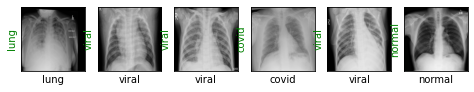

In [22]:
show_preds()

In [34]:
resnet18 = resnet18.to(device)
resnet18.eval()

preds = torch.Tensor([])
labels = torch.Tensor([])
for val_step, (batch_images, batch_labels) in enumerate(test_loader):
    batch_images = batch_images.to(device)
    batch_labels = batch_labels.to(device)
    
    outputs = resnet18(batch_images)
    _, batch_preds = torch.max(outputs, 1)
    batch_preds = batch_preds.cpu().detach()
    batch_labels = batch_labels.cpu().detach()
    
    preds = torch.cat([preds, batch_preds], dim=0)
    labels = torch.cat([labels, batch_labels], dim=0)

In [35]:
labels = labels.numpy()
preds = preds.numpy()

<Figure size 432x288 with 0 Axes>

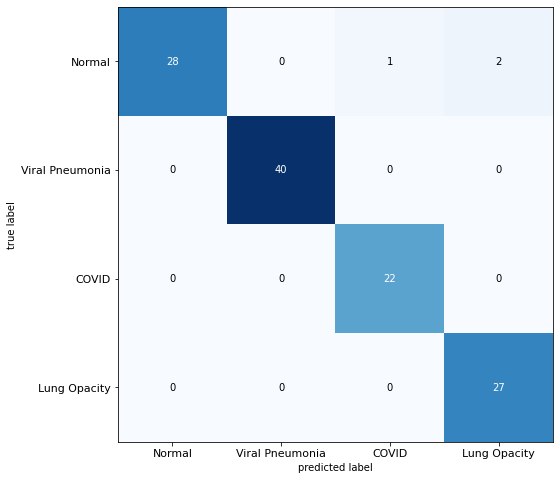

In [36]:
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), class_fullnames, fontsize=11)
plt.yticks(range(4), class_fullnames, fontsize=11)
plt.show()

In [45]:
print(f'Total accuracy: {np.sum(labels == preds) / len(labels) * 100.}%')

Total accuracy: 97.5%


In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')